# EDA for model features
Install the snowflake-connector-python if needed

In [3]:
#!pip install snowflake-connector-python

In [39]:
import pandas as pd
import numpy as np
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv

# enable pandas to display up to 500 columns
pd.set_option('display.max_columns', 500)

#### 1.1 Load Snowflake credentials for temp user

In [5]:
# Load environment variables from a .env file
load_dotenv()

try:
    TEMP_USER = os.getenv('SNOWSQL_TEMP_USER')
    TEMP_USER_PASSWORD = os.getenv('SNOWSQL_TEMP_PWD')
    
    if not TEMP_USER:
        raise ValueError("Environment variable SNOWSQL_TEMP_USER must be set")
    if not TEMP_USER_PASSWORD:
        raise ValueError("Environment variable SNOWSQL_TEMP_PWD must be set")

except ValueError as ve:
    print(f"Error: {ve}")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

#### 1.2 Connect to Snowflake

In [6]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account='ygeuort-alb19263',
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='ODS'
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

Connected to Snowflake successfully at 2024-07-19 15:2408


## 2. Fetch data from Snowflake

### Table Information

The following tables exist in the ODS schema:

**listings table**:  contains data on listings
- Number of rows:  111K.
- Date columns: 'last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review'

**reviews table**:  contains reviews for listings
- Number of rows: 4.1M rows.
- Date columns: 'review_date'

### Market Names

Market names are stored under the column `market` for each table and markets are labeled as follows:
- albany
- chicago
- los-angeles
- new-york-city
- san-francisco
- seattle
- washington-dc

#### 2.1 Function to fetch data from Snowflake

In [7]:
def get_data(sql_query, date_columns=None):
    """
    Executes a SQL query and returns the result as a pandas DataFrame.

    Args:
        sql_query (str): SQL query to execute.

    Returns:
        df_result: Resulting DataFrame from the SQL query.
    """
    try:
        cursor = conn.cursor()
        
        cursor.execute(sql_query)

        # load data into dataframe
        df_result = cursor.fetch_pandas_all()

        # Convert column names to lowercase
        df_result.columns = map(str.lower, df_result.columns)

        # Parse specified date columns
        if date_columns:
            for col in date_columns:
                df_result[col] = pd.to_datetime(df_result[col], errors='coerce')

    finally:
        if cursor is not None:
            cursor.close()

    return df_result

#### 2.2 Sample query
Select listings data for albany market.

In [47]:
sql_query = '''
select * from listings
where market = 'chicago'
 '''

df = get_data(sql_query)
df.shape

(7707, 68)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7707 entries, 0 to 7706
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7707 non-null   int64  
 1   scrape_id                                     7707 non-null   int64  
 2   last_scraped                                  7707 non-null   object 
 3   name                                          7707 non-null   object 
 4   description                                   7622 non-null   object 
 5   neighborhood_overview                         5428 non-null   object 
 6   host_id                                       7707 non-null   int32  
 7   host_name                                     7707 non-null   object 
 8   host_since                                    7707 non-null   object 
 9   host_location                                 6288 non-null   o

In [49]:
df.head()

,id,scrape_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,market
0,2384,20240323200240,2024-03-23,Hyde Park - Walk to UChicago,You are invited stay in the guest room of my v...,The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, IL",My apartment is a 2nd floor walk-up in a centu...,within an hour,100.0,91.0,1,Hyde Park,1,1,"email, phone",t,t,"Chicago, Illinois, United States",Hyde Park,41.787900,-87.587800,Private room in condo,Private room,1,1.0,1 shared bath,1.0,1.0,"Free washer - In building, Coffee, Books and r...",86.0,3,89,2,3,1125,1125,3.0,1125.0,t,13,36,62,309,2024-03-23,234,23,2,2015-01-09,2024-03-12,4.99,4.98,4.99,4.99,4.98,4.96,4.94,R17000015609,f,1,0,1,0,2.09,chicago
1,7126,20240323200240,2024-03-24,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhood.,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, IL",We live in Chicago. We love to travel and see ...,within an hour,100.0,100.0,1,Ukrainian Village,1,2,"email, phone",t,t,"Chicago, Illinois, United States",West Town,41.901660,-87.680210,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"Smart lock, Books and reading material, Window...",90.0,2,60,2,2,1125,1125,2.0,1125.0,t,20,43,61,294,2024-03-24,516,31,1,2009-07-03,2024-03-03,4.70,4.85,4.56,4.90,4.87,4.89,4.75,R24000114046,f,1,1,0,0,2.88,chicago
2,10945,20240323200240,2024-03-24,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,None,33004,At Home Inn,2009-08-21,"Chicago, IL","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,97.0,93.0,1,Old Town,9,86,"email, phone, work_email",t,t,None,Lincoln Park,41.911960,-87.639810,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,2.0,"Free washer - In building, Lake access, Window...",114.0,4,120,2,4,1125,1125,3.9,1125.0,t,6,19,26,162,2024-03-24,83,23,1,2014-04-28,2024-03-06,4.65,4.80,4.80,4.80,4.84,4.98,4.66,2209984,t,6,6,0,0,0.69,chicago
3,12140,20240323200240,2024-03-24,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Shay And Robert,2009-10-18,"Chicago, IL",Best in the city with long-time urban-dwelling...,within a day,100.0,100.0,0,Lincoln Park,1,1,"email, phone",t,t,"Chicago, Illinois, United States",Lincoln Park,41.923570,-87.649470,Room in boutique hotel,Private room,3,1.0,1 private bath,1.0,1.0,"Fire extinguisher, Iron, Heating, Shampoo, Han...",329.0,2,10,1,2,10,10,2.0,10.0,t,29,54,78,165,2024-03-24,15,2,0,2015-06-29,2023-05-21,4.93,4.67,5.00,5.00,5.00,5.00,4.87,R20000055258,f,1,0,1,0,0.14,chicago
4,24833,20240323200240,2024-03-24,Prime LincolnPark 1 Block Fullerton Express L ...,Perfect private entrance apartment one block f...,Lincoln Park is a great neighborhood where peo...,101521,Red,2010-03-31,"Chicago, IL",Travel

In [97]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#features:
# host response rate, host acceptance rate
# host is superhost neighborhood_cleansed, host has profile picture, host identity verified, room type, accommodates, bathrooms, beds, review_scores_rating, instant_bookable, market
#predict price
# Convert 'datetime.date' columns to 'datetime64'
date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'host_has_profile_pic', 'host_identity_verified', 'room_type', 'accommodates', 'bathrooms', 'beds', 'review_scores_rating', 'instant_bookable', 'market']
cols_to_encode = ['market', 'room_type', 'instant_bookable',  'neighbourhood_cleansed', 'host_has_profile_pic', 'host_identity_verified']
target = 'price'

df_no_dt = df.drop(columns=date_cols)
# Create the ColumnTransformer with OneHotEncoder
# Create the encoder
encoder = OneHotEncoder(sparse=False, dtype=np.int8)

# Create a column transformer
ct = ColumnTransformer(transformers=[('encoder', encoder, cols_to_encode)], remainder='passthrough')

# Fit and transform the data
df_encoded = ct.fit_transform(df_no_dt)

# Get the feature names from the encoder
feature_names = ct.named_transformers_['encoder'].get_feature_names(input_features=cols_to_encode)

# Get the remaining column names from the original DataFrame
remaining_cols = [col for col in df_no_dt.columns if col not in cols_to_encode]

# Combine the encoded feature names with the remaining column names
all_cols = list(feature_names) + remaining_cols

# Convert the numpy array to a DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=all_cols)
# Select only the object columns
df_objects = df_encoded.select_dtypes(include=['object'])

# Convert all object columns to numeric
df_encoded[df_objects.columns] = df_objects.apply(pd.to_numeric, errors='coerce')

/Users/samkobrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [102]:
list(features)

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'neighbourhood_cleansed',
 'host_has_profile_pic',
 'host_identity_verified',
 'room_type',
 'accommodates',
 'bathrooms',
 'beds',
 'review_scores_rating',
 'instant_bookable',
 'market']

In [112]:
# create model columns
model_cols = [col for col in df_no_dt.columns if col not in cols_to_encode]

# Combine the encoded feature names with the remaining column names
all_cols = list(feature_names) + list(["price", "bathrooms", "beds", "accommodates", "host_response_rate", "host_acceptance_rate"])

#select relivant columns
df_encoded = df_encoded[all_cols]

# Fill NA values with the column mean
df_encoded = df_encoded.fillna(df_encoded.mean())


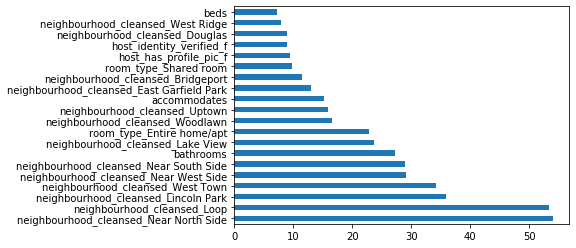

In [115]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define the target variable and the feature matrix
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LassoCV model
lasso = LassoCV(cv=5)

# Fit the model
lasso.fit(X_train, y_train)

# Get the feature importance
importance = pd.Series(abs(lasso.coef_), index = X.columns)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LassoCV model
lasso = LassoCV(cv=5)

# Fit the model
lasso.fit(X_train, y_train)

# Get the feature importance
importance = pd.Series(abs(lasso.coef_), index = X.columns)

# Plot the feature importance
importance.nlargest(20).plot(kind='barh')

# Display the plot
import matplotlib.pyplot as plt
plt.show()


In [16]:
import seaborn as sns

# Create a pairplot of the DataFrame
sns.pairplot(df_encoded['price'])

# Display the plot
import matplotlib.pyplot as plt
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7d135bcc10> (for post_execute):


KeyboardInterrupt: 

### 2.3 Sample query with date conversion for date columns
All Listings data and convert date columns to date type.

In [9]:
date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

sql_query = '''
select * from listings
 '''

df = get_data(sql_query, date_columns=date_cols)
df.shape

(111052, 68)

In [ ]:
df.info()

#### 2.4 Sample query for Reviews
Reviews table contains 4 million reviews. For now just pull in 100 reviews.

In [ ]:
date_cols = ['review_date']

sql_query = '''
select * from reviews
limit 100
 '''

df = get_data(sql_query, date_columns=date_cols)
df.shape

In [ ]:
df.head()

In [ ]:
df.info()

## 3. Loading data into Snowflake
After performing feature engineering, the data will be stored in a schema called `feature_store`.

In this example we retrieve listings for Albany and prase the dates but limit to the first 10 rows.
#### 3.1 Load data

In [ ]:
date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

sql_query = '''
select * from listings
where market = 'albany'
limit 10
 '''

df = get_data(sql_query, date_columns=date_cols)
df.shape

#### 3.2 Create new feature

In [ ]:
df['new_feature'] = 'feature'

In [ ]:
df.head(2)

#### 3.3 Connect to FEATURE_STORE schema

In [ ]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account='ygeuort-alb19263',
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='FEATURE_STORE' # connect to feature_store
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

#### 3.4 Create table and upload to Snowflake

In [ ]:
from snowflake.connector.pandas_tools import write_pandas

In [ ]:
def write_to_snowflake(df_name, snowflake_table_name):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')
    try:
        success, num_chunks, num_rows, output = write_pandas(
            conn=conn,
            df=df_name,
            schema='FEATURE_STORE', # schema needs to be capitalized
            table_name=snowflake_table_name,
            auto_create_table=True,
            overwrite=True
        )

        print(f'Created table and data loaded to Snowflake at {current_time}')

    except Exception as e:
        print(f'Failed to create table and load data to Snowflake due to error code {e}')

In [ ]:
write_to_snowflake(df, 'ALBANY_MARKET_LISTINGS')